**FINAL PROJECT SAP**

_Working Hypothesis:_

My working hypothesis is that higher urinary glyphosate concentrations are associated with elevated levels of oxidative stress biomarkers during pregnancy. I expect these associations to be positive and potentially nonlinear, reflecting biological pathways through which pesticide exposures may influence oxidative stress.

_Research Questions:_

1. How do urinary glyphosate concentrations relate to oxidative stress biomarkers among pregnant women?
2. Do demographic or lifestyle factors such as maternal age, BMI, race, or diet confound or modify the associations between glyphosate exposure and oxidative stress?
3. Is the relationship between glyphosate or AMPA exposure and oxidative stress linear, or do generalized additive models suggest nonlinear exposure–response patterns?

**Objective 1: Dataset**

The data has been simulated and stored as simdata.xlsx. It's located in the data folder.

In [158]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from scipy.stats import gmean
from IPython.display import display, Markdown
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.gam.api import GLMGam, BSplines
import matplotlib.pyplot as plt
data_path = os.path.join("data", "simdata.xlsx")
df = pd.read_excel(data_path)

**Objective 2: Summary Statistics**

*Packages needed: pandas, numpy, scipy.stats

_1. Demographic Categorical and Continuous Variables_

For all categorical variables, including maternal race, education, employment status and marital status, I will calculate counts and percentages. For all continuous variables, including maternal age, pre-pregnancy bmi, and alternative healthy eating index score, I will calculate means and standard deviations. These summaries will provide a clear overview of the sample composition and allow me to identify differences in the distribution of participant characteristics.

_2. Exposure Variable_

Since glyphosate concentrations are right-skewed, I will summarize them using geometric means (GM) and geometric standard deviations (GSD). I will compute these overall and stratified by each categorical covariate. This will help identify whether certain demographic groups have higher or lower pesticide exposure, which may inform later decisions about confounding or effect modification.

_3. Descriptive Tables_

I will present the descriptive statistics in two tables:
Table 1: Descriptive characteristics of the sample (categorical: n (%); continuous: mean (SD))
Table 2: Geometric means and GSDs of glyphosate, overall and stratified by covariates

In [165]:
# categorical and continuous variables were cleaned before simulating the data (I condensed some groups of the categorical variables to handle sparse data)
#sample size!
print(f"Sample size: {df.shape[0]}")
# step 1: defining groups
rename_vars = {
    "mat_race_eth.sim": "mat_race_eth",
    "mat_educ.sim": "mat_educ",
    "employ.sim": "employ",
    "marital.sim": "marital",
    "parity.sim": "parity",
    "mat_age.sim": "mat_age",
    "ppbmi.sim": "ppbmi",
    "aehi.sim": "aehi"
}
df = df.rename(columns=rename_vars)
categorical_vars = [
    "mat_race_eth",
    "mat_educ",
    "employ",
    "marital",
    "parity"
]

# step 1: summary stats for categorical variables
cat_summary = {}

for var in categorical_vars:
    counts = df[var].value_counts(dropna=False)
    percents = df[var].value_counts(normalize=True, dropna=False) * 100

    cat_summary[var] = pd.DataFrame({
        "Count": counts,
        "Percent": percents.round(1)
    })
# print(cat_summary)

labels = {
    "mat_race_eth": {1: "White", 2: "Non-white"},
    "mat_educ": {2: "HS/some college", 3: "College", 4: "Graduate degree"},
    "employ": {1: "Employed", 2: "Unemployed"},
    "marital": {1: "Married", 2: "Unmarried"},
    "parity": {0: "No prior births", 1: "1+ births"}
}

rows = []

for var, table in cat_summary.items():
    for level, stats_row in table.iterrows():
        label = labels.get(var, {}).get(level, level)
        rows.append({
            "Variable": var,
            "Label": label,
            "N (%)": f"{int(stats_row['Count'])} ({stats_row['Percent']}%)"
        })
table1_categorical = pd.DataFrame(rows)
display(Markdown("### Table 1. Descriptive characteristics of the sample (Categorical)"))
display(table1_categorical.style.hide(axis="index"))

Sample size: 161


### Table 1. Descriptive characteristics of the sample (Categorical)

Variable,Label,N (%)
mat_race_eth,Non-white,126 (78.3%)
mat_race_eth,White,35 (21.7%)
mat_educ,Graduate degree,77 (47.8%)
mat_educ,College,67 (41.6%)
mat_educ,HS/some college,17 (10.6%)
employ,Employed,137 (85.1%)
employ,Unemployed,24 (14.9%)
marital,Married,142 (88.2%)
marital,Unmarried,19 (11.8%)
parity,1+ births,99 (61.5%)


In [166]:
continuous_vars = [
    "mat_age",
    "ppbmi",
    "aehi"
]
# step 1: summary stats for continuous variables:
cont_summary = {}

for var in continuous_vars:
    cont_summary[var] = pd.DataFrame({
        "Mean": [df[var].mean()],
        "SD": [df[var].std()]
    })
# print(cont_summary)
cont_labels = {
    "mat_age": "Maternal age (years)",
    "ppbmi": "Pre-pregnancy BMI (kg/m²)",
    "aehi": "Alternate Healthy Eating Index score"
}
rows_cont = []

for var, stats_row in cont_summary.items():
    mean_val = round(stats_row["Mean"].iloc[0], 2)
    sd_val = round(stats_row["SD"].iloc[0], 2)

    rows_cont.append({
        "Variable": var,
        "Label": cont_labels.get(var, var),
        "Mean (SD)": f"{mean_val} ({sd_val})"
    })

table1_continuous = pd.DataFrame(rows_cont)
display(Markdown("### Table 1. Descriptive characteristics of the sample (Continuous)"))
display(table1_continuous.style.hide(axis="index"))

### Table 1. Descriptive characteristics of the sample (Continuous)

Variable,Label,Mean (SD)
mat_age,Maternal age (years),30.45 (4.4)
ppbmi,Pre-pregnancy BMI (kg/m²),26.16 (5.04)
aehi,Alternate Healthy Eating Index score,2.25 (1.59)


In [167]:
# step 2
glyph = "Glyphosate_PA_SG.sim"

def geo_sd(x):
    x = x[x > 0]
    return np.exp(np.std(np.log(x)))

gm = gmean(df[glyph][df[glyph] > 0], axis=0)
gsd = geo_sd(df[glyph])

strat_tables = {}

for cat in categorical_vars:
    tbl = df.groupby(cat)[glyph].apply(
        lambda x: pd.Series({
            "geo_mean": gmean(x[x > 0], axis=0),
            "geo_sd": geo_sd(x)
        })
    ).reset_index()
    tbl = tbl.set_index(cat)
    strat_tables[cat] = tbl

#print(gm)
#print(gsd)
#print(strat_tables)

rows_glyph = []

rows_glyph.append({
    "Label": "Overall",
    "GM (GSD)": f"{round(gm, 3)} ({round(gsd, 2)})"
})

for var, table in strat_tables.items():
    # Convert long → wide so we get geo_mean and geo_sd in columns
    tmp = table.reset_index()
    tmp = tmp.pivot(index=tmp.columns[0], columns="level_1", values=tmp.columns[-1])
    tmp.columns = ["geo_mean", "geo_sd"]  # clean column names

    for level, vals in tmp.iterrows():
        label = labels.get(var, {}).get(level, level)
        gm_val = round(vals["geo_mean"], 3)
        gsd_val = round(vals["geo_sd"], 2)

        rows_glyph.append({
            "Variable": var,
            "Label": label,
            "GM (GSD)": f"{gm_val} ({gsd_val})"
        })

table2 = pd.DataFrame(rows_glyph)
display(Markdown("### Table 2. Stratified Glyphosate Summary"))
display(table2.style.hide(axis="index"))

### Table 2. Stratified Glyphosate Summary

Label,GM (GSD),Variable
Overall,0.224 (2.69),nan
White,0.207 (3.12),mat_race_eth
Non-white,0.229 (2.57),mat_race_eth
HS/some college,0.192 (2.71),mat_educ
College,0.235 (2.54),mat_educ
Graduate degree,0.222 (2.8),mat_educ
Employed,0.223 (2.76),employ
Unemployed,0.228 (2.27),employ
Married,0.226 (2.65),marital
Unmarried,0.207 (2.98),marital


**Objective 3: Statistical Analysis Plan**

To address my research questions, I will begin by preparing the dataset for analysis. This includes restricting the dataset to complete cases, renaming outcome variables to ensure clear scientific interpretation, checking distributions, and verifying that all variables are coded with the correct data types. Because glyphosate and the oxidative stress biomarkers are right-skewed, I will log-transform the exposure and outcome variables prior to modeling. These steps, which support the assumptions required for later analyses and directly contribute to answering Research Question 1, will be completed using pandas and numpy. Once the dataset is cleaned, I will generate descriptive statistics as previously outlined using pandas, including geometric means calculated via numpy (and custom functions) to understand the distribution of glyphosate across demographic groups. To estimate unadjusted associations between glyphosate and each oxidative stress biomarker (Research Question 1), I will fit separate ordinary least squares (OLS) linear regressions with log-glyphosate as the exposure and each log-transformed biomarker as the outcome using statsmodels.api.OLS. These models will provide β coefficients, 95% confidence intervals, and p-values. To identify potential covariates for adjusted models (Research Question 2), I will evaluate relationships between glyphosate, biomarkers, and demographic variables using t-tests and one-way ANOVA for categorical predictors, and Pearson correlations for continuous predictors, implemented through scipy.stats. Covariates associated with both the exposure and the outcome at p < 0.10 will be included in multivariable models. I will then fit adjusted OLS regression models using statsmodels to assess whether demographic or lifestyle factors confound or modify the association between glyphosate and oxidative stress, directly addressing Research Question 2. Finally, to explore potential nonlinearity in the exposure–response relationship (Research Question 3), I will fit generalized additive models (GAMs) with spline terms using statsmodels.gam.api.GLMGam and BSplines. These models will allow me to visualize and statistically test nonlinear patterns between glyphosate and each biomarker.

In [168]:
# My mentor and I decided to drop the 2 derived variables from my thesis recently, sp I'll be log transforming and cleaning the names of the remaining 4:
ox = [
    "iso_sg_avg.sim",
    "isom_sg_avg.sim",
    "isom_new_sg_avg.sim",
    "pgf_sg_avg.sim"
]

for var in ox:
    clean_name = var.replace(".", "_")
    df[f"log_{clean_name}"] = np.log(df[var] + 1)

df = df.rename(columns={"log_Glyphosate_PA_SG.sim": "log_Glyphosate_PA_SG_sim"})

In [175]:
# RESEARCH QUESTION 1: performing unadjusted linear regressions
exposure = "log_Glyphosate_PA_SG_sim"

outcomes = [
    "log_iso_sg_avg_sim",
    "log_isom_sg_avg_sim",
    "log_isom_new_sg_avg_sim",
    "log_pgf_sg_avg_sim"
]

label_map = {
    "log_iso_sg_avg_sim": "8-iso-PGF₂α",
    "log_isom_sg_avg_sim": "2,3-dinor-5,6-dihydro-8-iso-PGF₂α",
    "log_isom_new_sg_avg_sim": "2,3-dinor-8-iso-PGF₂α",
    "log_pgf_sg_avg_sim": "PGF₂α"
}

results_list = []

for outcome in outcomes:
    formula = f"{outcome} ~ {exposure}"
    model = smf.ols(formula=formula, data=df).fit()

    beta = model.params[exposure]
    ci_lower, ci_upper = model.conf_int().loc[exposure]
    pval = model.pvalues[exposure]

    results_list.append({
        "Outcome": label_map[outcome],
        "Beta": beta,
        "CI_lower": ci_lower,
        "CI_upper": ci_upper,
        "p-value": pval
    })

ols_results = pd.DataFrame(results_list)
print("\nUnadjusted Associations Between Glyphosate and Oxidative Stress Biomarkers\n")
print(ols_results.to_string(index=False))


Unadjusted Associations Between Glyphosate and Oxidative Stress Biomarkers

                          Outcome      Beta  CI_lower  CI_upper  p-value
                      8-iso-PGF₂α -0.003317 -0.037522  0.030888 0.848352
2,3-dinor-5,6-dihydro-8-iso-PGF₂α -0.004870 -0.062863  0.053122 0.868475
            2,3-dinor-8-iso-PGF₂α  0.004046 -0.042966  0.051058 0.865236
                            PGF₂α  0.015911 -0.040372  0.072194 0.577414


In [180]:
# RESEARCH QUESTION 2: identifying potential covariates and running adjusted regressions if needed
cat_exp_pvals = []

for var in categorical_vars:
    groups = [df[exp][df[var] == level].dropna() for level in df[var].dropna().unique()]

    if len(groups) == 2:
        stat, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
    else:
        stat, p = stats.f_oneway(*groups)

    cat_exp_pvals.append({"Variable": var, "p-value": p})

cat_exp_pvals = pd.DataFrame(cat_exp_pvals)
cat_exp_pvals
cat_outcome_pvals = {}

for outcome in outcomes:
    rows = []
    for var in categorical_vars:
        groups = [df[outcome][df[var] == level].dropna() for level in df[var].dropna().unique()]
        if len(groups) == 2:
            stat, p = stats.ttest_ind(groups[0], groups[1], equal_var=False)
        else:
            stat, p = stats.f_oneway(*groups)
        rows.append({"Variable": var, "p-value": p})

    cat_outcome_pvals[outcome] = pd.DataFrame(rows)
cont_exp_pvals = []

for var in continuous_vars:
    r, p = stats.pearsonr(df[exp], df[var])
    cont_exp_pvals.append({"Variable": var, "p-value": p, "r": r})

cont_exp_pvals = pd.DataFrame(cont_exp_pvals)
cont_exp_pvals
cont_outcome_pvals = {}

for outcome in outcomes:
    rows = []
    for var in continuous_vars:
        r, p = stats.pearsonr(df[outcome], df[var])
        rows.append({"Variable": var, "p-value": p, "r": r})

    cont_outcome_pvals[outcome] = pd.DataFrame(rows)
print("Categorical vs Glyphosate")
display(cat_exp_pvals)

print("Continuous vs Glyphosate")
display(cont_exp_pvals)

for outcome in outcomes:
    scientific = label_map[outcome]

    print(f"\nCategorical vs {scientific}")
    display(cat_outcome_pvals[outcome])

    print(f"Continuous vs {scientific}")
    display(cont_outcome_pvals[outcome])


print(f"There are no variables associated with both the exposure and outcome at p<0.1, therefore there are no covariates to adjust for. I will be only visualizing the unadjusted regression results due to this.")

Categorical vs Glyphosate


,Variable,p-value
0,mat_race_eth,0.895426
1,mat_educ,0.670381
2,employ,0.418515
3,marital,0.678466
4,parity,0.804403


Continuous vs Glyphosate


,Variable,p-value,r
0,mat_age,0.150601,0.113802
1,ppbmi,0.959325,-0.004051
2,aehi,0.380822,0.069527



Categorical vs 8-iso-PGF₂α


,Variable,p-value
0,mat_race_eth,0.200779
1,mat_educ,0.713780
2,employ,0.186032
3,marital,0.663464
4,parity,0.021276


Continuous vs 8-iso-PGF₂α


,Variable,p-value,r
0,mat_age,0.742542,0.026087
1,ppbmi,0.723222,-0.028125
2,aehi,0.919836,-0.007994



Categorical vs 2,3-dinor-5,6-dihydro-8-iso-PGF₂α


,Variable,p-value
0,mat_race_eth,0.274854
1,mat_educ,0.027674
2,employ,0.732928
3,marital,0.017468
4,parity,0.301183


Continuous vs 2,3-dinor-5,6-dihydro-8-iso-PGF₂α


,Variable,p-value,r
0,mat_age,0.253090,-0.090592
1,ppbmi,0.849454,0.015076
2,aehi,0.923633,-0.007614



Categorical vs 2,3-dinor-8-iso-PGF₂α


,Variable,p-value
0,mat_race_eth,0.175290
1,mat_educ,0.266365
2,employ,0.207673
3,marital,0.914468
4,parity,0.206603


Continuous vs 2,3-dinor-8-iso-PGF₂α


,Variable,p-value,r
0,mat_age,0.846797,0.015346
1,ppbmi,0.168110,-0.109151
2,aehi,0.371157,-0.070945



Categorical vs PGF₂α


,Variable,p-value
0,mat_race_eth,0.527009
1,mat_educ,0.926651
2,employ,0.566367
3,marital,0.106017
4,parity,0.894320


Continuous vs PGF₂α


,Variable,p-value,r
0,mat_age,0.480745,-0.055963
1,ppbmi,0.501511,-0.053348
2,aehi,0.273945,-0.086734


There are no variables associated with both the exposure and outcome at p<0.1, therefore there are no covariates to adjust for. I will be only visualizing the unadjusted regression results due to this.


In [193]:
#RESEARCH QUESTION 3: generalized additive models to examine non-linearity

from statsmodels.gam.api import BSplines, GLMGam
from statsmodels.genmod.families import Gaussian

x = df[[exp]]  # must be 2D
bs = BSplines(x, df=[5], degree=[3])

gam_results = {}

for outcome in outcomes:
    y = df[outcome]

    # Include spline basis directly in the model
    exog = np.ones((len(df), 1))  # intercept

    gam_model = GLMGam(
        y,
        exog=exog,
        smoother=bs,
        family=Gaussian()
    )

    gam_fit = gam_model.fit()
    gam_results[outcome] = gam_fit

    print(f"\nGAM Results for {label_map[outcome]}")
    print(gam_fit.summary())


GAM Results for 8-iso-PGF₂α
                 Generalized Linear Model Regression Results                  
Dep. Variable:     log_iso_sg_avg_sim   No. Observations:                  161
Model:                         GLMGam   Df Residuals:                      156
Model Family:                Gaussian   Df Model:                         4.00
Link Function:               Identity   Scale:                        0.092406
Method:                         PIRLS   Log-Likelihood:                -34.193
Date:                Fri, 05 Dec 2025   Deviance:                       14.415
Time:                        20:01:07   Pearson chi2:                     14.4
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01551
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

**Objective 4: Visualizations**

First, to address Research Question 1, I will generate a forest-style plot showing the β estimates and 95% confidence intervals from the unadjusted linear regressions between log-glyphosate and each oxidative stress biomarker. This figure will be titled “Unadjusted Associations Between Glyphosate and Oxidative Stress Biomarkers” with the x-axis labeled “Beta Estimate (95% CI)” and the y-axis labeled with biomarker names. To address Research Questions 1 and 2, I will produce a second forest plot summarizing the adjusted regression results, titled “Adjusted Associations Between Glyphosate and Oxidative Stress Biomarkers,” using the same axis labels for consistency. Finally, to explore Research Question 3, I will create a 3×2 multipanel GAM plot (one panel per biomarker) showing the smooth function of log-glyphosate with 95% confidence bands. Each panel will have a brief descriptive title, with the x-axis labeled “log(Glyphosate)” and the y-axis labeled “Partial Effect.” Together, these visualizations will help clarify both the linear and potential nonlinear relationships between glyphosate and oxidative stress biomarkers.

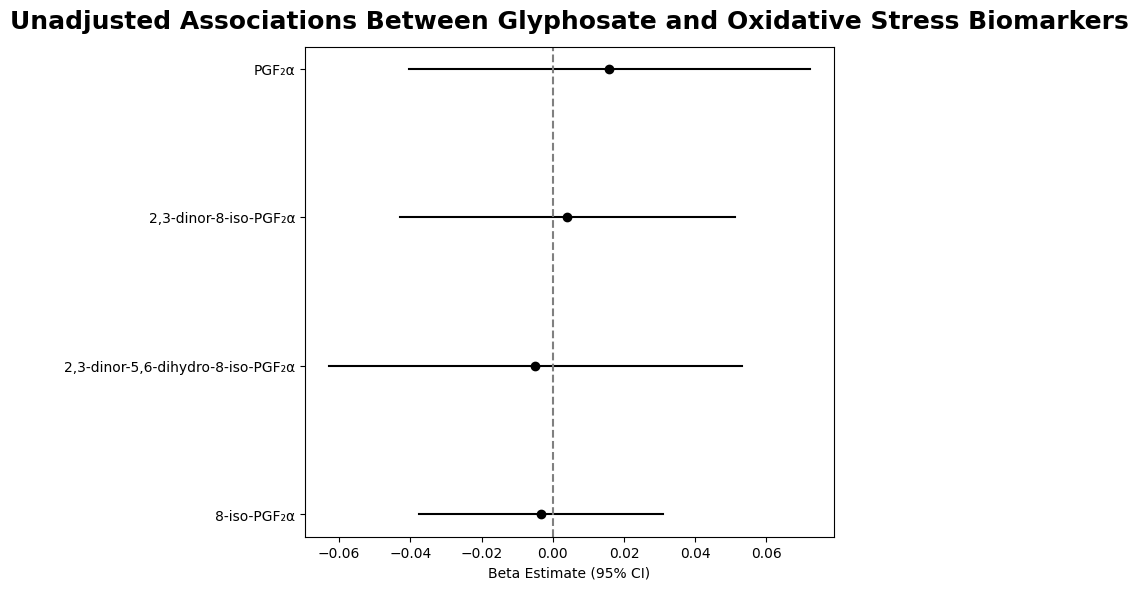

In [199]:
# VISUALIZATION 1: Unadjusted linear regression plot
plt.figure(figsize=(8, 6))

y_positions = range(len(ols_results))

plt.scatter(ols_results["Beta"], y_positions, color="black")

for i, row in ols_results.iterrows():
    plt.plot([row["CI_lower"], row["CI_upper"]], [i, i], color="black")

plt.axvline(0, color='gray', linestyle='--')

plt.yticks(y_positions, ols_results["Outcome"])
plt.xlabel("Beta Estimate (95% CI)")
plt.title("Unadjusted Associations Between Glyphosate and Oxidative Stress Biomarkers",
    fontsize=18,
    weight="bold",
    y=1.02 )

plt.tight_layout()
plt.show()

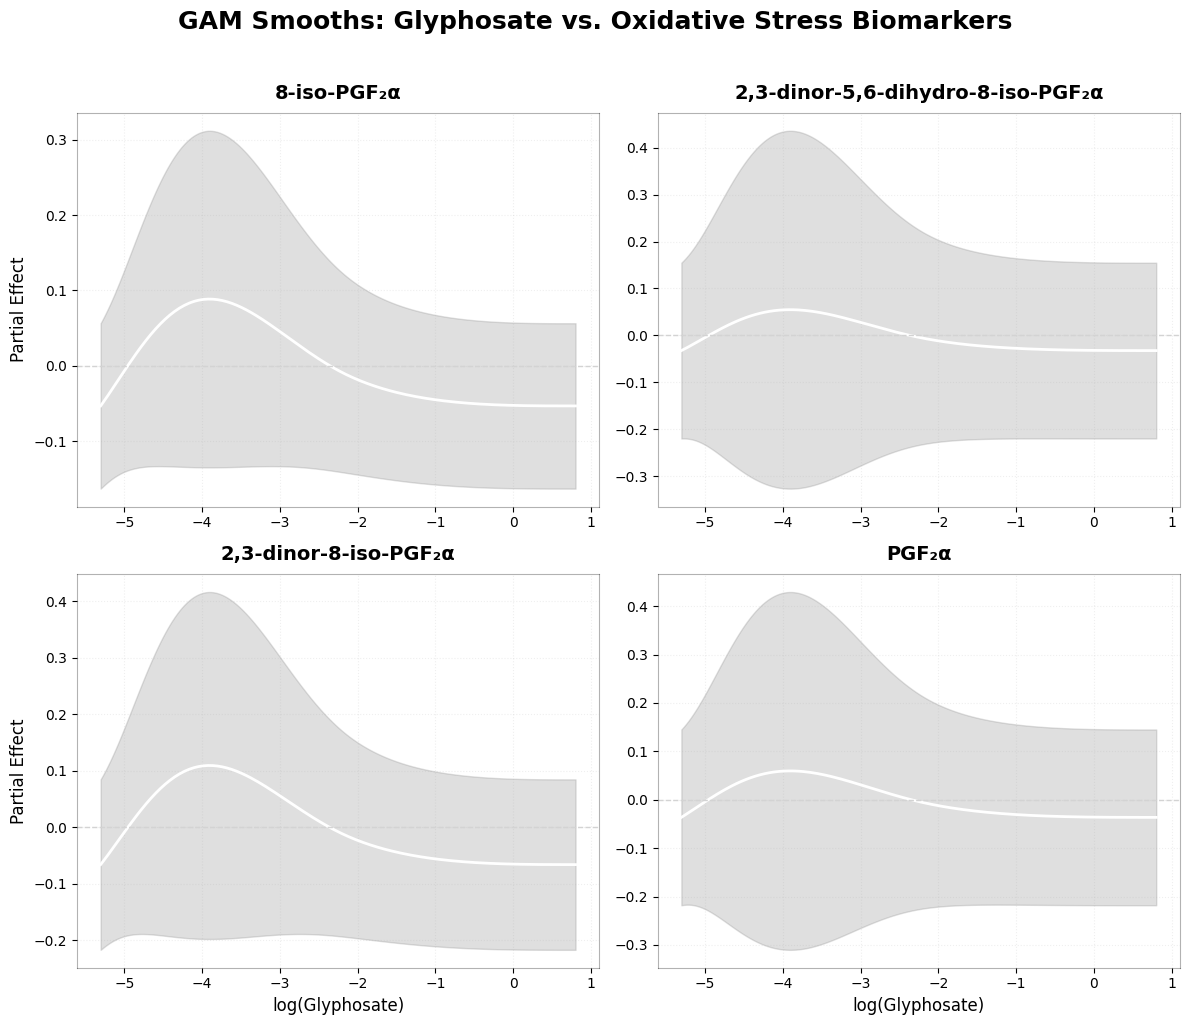

In [197]:
# GAM plots
x_pred = np.linspace(df[exp].min(), df[exp].max(), 200)
gam_pred = {}

for outcome in outcomes:
    model = gam_results[outcome]

    # Exog matrix = intercept only
    exog_pred = np.ones((len(x_pred), 1))

    # Smoother prediction matrix
    bs = model.model.smoother
    exog_smooth_pred = bs.transform(x_pred.reshape(-1, 1))

    # Compute predictions
    pred_res = model.get_prediction(
        exog=exog_pred,
        exog_smooth=exog_smooth_pred
    )

    fit = pred_res.predicted_mean
    se = pred_res.se_mean

    # Partial effect (center for visualization)
    fit_centered = fit - fit.mean()

    gam_pred[outcome] = pd.DataFrame({
        "x": x_pred,
        "fit": fit_centered,
        "lower": fit_centered - 1.96 * se,
        "upper": fit_centered + 1.96 * se
    })

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, outcome in enumerate(outcomes):
    ax = axes[i]
    biomarker = label_map[outcome]
    pred = gam_pred[outcome]

    ax.plot(
        pred["x"], pred["fit"],
        color="white", linewidth=2
    )

    ax.fill_between(
        pred["x"],
        pred["lower"],
        pred["upper"],
        color="gray",
        alpha=0.25
    )

    ax.set_title(
        biomarker,
        fontsize=14,
        weight="bold",
        pad=10
    )

    if i < 2:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("log(Glyphosate)", fontsize=12)

    if i % 2 == 1:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Partial Effect", fontsize=12)

    ax.axhline(0, color="lightgray", linestyle="--", linewidth=1)
    ax.grid(alpha=0.2, linestyle=":")

    for spine in ax.spines.values():
        spine.set_alpha(0.3)

for j in range(len(outcomes), 4):
    fig.delaxes(axes[j])

fig.suptitle(
    "GAM Smooths: Glyphosate vs. Oxidative Stress Biomarkers",
    fontsize=18,
    weight="bold",
    y=1.02
)
plt.tight_layout()
plt.show()